In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os
import pickle as cPickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

import kde
import simplebinmi

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')

import utils

# load data network was trained on
trn, tst = utils.get_IB_data('2017_12_21_16_51_3_275766')
# trn, tst = utils.get_mnist()

# calc MI for train and test. Save_activations must have been run with cfg['FULL_MI'] = True
FULL_MI = True

# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'

DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 10000      # Max number of epoch for which to compute mutual information measure
NUM_LABELS = 2
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 10000

# Directories from which to load saved layer activity
# ARCH = '1024-20-20-20'
ARCH = '10-7-5-4-3'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
#ARCH = '32-28-24-20-16-12-8-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-3                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

# Save indexes of tests data for each of the output classes
saved_labelixs = {}

y = tst.y
Y = tst.Y
if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

/home/luke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}
measures['relu'] = {}
# measures['softsign'] = {}
# measures['softplus'] = {}

Compute MI measures
-----

In [4]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(NUM_LABELS):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(NUM_LABELS):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binned estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
                        
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata

*** Doing rawdata/tanh_10-7-5-4-3 ***
Doing rawdata/tanh_10-7-5-4-3/epoch00000000
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.325, MI(Y;M)=0.783
- Layer 3 upper: MI(X;M)=9.041, MI(Y;M)=0.344
- Layer 4 upper: MI(X;M)=6.023, MI(Y;M)=0.145
- Layer 5 upper: MI(X;M)=1.429, MI(Y;M)=0.015
Doing rawdata/tanh_10-7-5-4-3/epoch00000001
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.314, MI(Y;M)=0.788
- Layer 3 upper: MI(X;M)=8.986, MI(Y;M)=0.350
- Layer 4 upper: MI(X;M)=5.912, MI(Y;M)=0.143
- Layer 5 upper: MI(X;M)=1.323, MI(Y;M)=0.008
Doing rawdata/tanh_10-7-5-4-3/epoch00000002
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.305, MI(Y;M)=0.790
- Layer 3 upper: MI(X;M)=8.943, MI(Y;M)=0.358
- Layer 4 upper: MI(X;M)=5.826, MI(Y;M)=0.143
- Layer 5 upper: MI(X;M)=1.258, MI(Y;M)

- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.641, MI(Y;M)=0.972
- Layer 3 upper: MI(X;M)=8.903, MI(Y;M)=0.798
- Layer 4 upper: MI(X;M)=5.972, MI(Y;M)=0.680
- Layer 5 upper: MI(X;M)=3.251, MI(Y;M)=0.639
Doing rawdata/tanh_10-7-5-4-3/epoch00000050
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.613, MI(Y;M)=0.973
- Layer 3 upper: MI(X;M)=8.804, MI(Y;M)=0.804
- Layer 4 upper: MI(X;M)=5.799, MI(Y;M)=0.684
- Layer 5 upper: MI(X;M)=3.144, MI(Y;M)=0.642
Doing rawdata/tanh_10-7-5-4-3/epoch00000055
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.591, MI(Y;M)=0.973
- Layer 3 upper: MI(X;M)=8.762, MI(Y;M)=0.810
- Layer 4 upper: MI(X;M)=5.696, MI(Y;M)=0.687
- Layer 5 upper: MI(X;M)=3.064, MI(Y;M)=0.644
Doing rawdata/tanh_10-7-5-4-3/epoch00000060
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999

- Layer 4 upper: MI(X;M)=6.583, MI(Y;M)=0.865
- Layer 5 upper: MI(X;M)=2.610, MI(Y;M)=0.804
Doing rawdata/tanh_10-7-5-4-3/epoch00000400
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.721, MI(Y;M)=0.986
- Layer 3 upper: MI(X;M)=10.546, MI(Y;M)=0.944
- Layer 4 upper: MI(X;M)=6.578, MI(Y;M)=0.869
- Layer 5 upper: MI(X;M)=2.567, MI(Y;M)=0.809
Doing rawdata/tanh_10-7-5-4-3/epoch00000420
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.722, MI(Y;M)=0.986
- Layer 3 upper: MI(X;M)=10.576, MI(Y;M)=0.945
- Layer 4 upper: MI(X;M)=6.603, MI(Y;M)=0.873
- Layer 5 upper: MI(X;M)=2.545, MI(Y;M)=0.814
Doing rawdata/tanh_10-7-5-4-3/epoch00000440
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.708, MI(Y;M)=0.984
- Layer 3 upper: MI(X;M)=10.561, MI(Y;M)=0.944
- Layer 4 upper: MI(X;M)=6.6

- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.655, MI(Y;M)=0.985
- Layer 3 upper: MI(X;M)=10.595, MI(Y;M)=0.961
- Layer 4 upper: MI(X;M)=6.551, MI(Y;M)=0.920
- Layer 5 upper: MI(X;M)=2.077, MI(Y;M)=0.873
Doing rawdata/tanh_10-7-5-4-3/epoch00000920
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.658, MI(Y;M)=0.985
- Layer 3 upper: MI(X;M)=10.610, MI(Y;M)=0.962
- Layer 4 upper: MI(X;M)=6.550, MI(Y;M)=0.921
- Layer 5 upper: MI(X;M)=2.060, MI(Y;M)=0.876
Doing rawdata/tanh_10-7-5-4-3/epoch00000940
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.656, MI(Y;M)=0.986
- Layer 3 upper: MI(X;M)=10.611, MI(Y;M)=0.962
- Layer 4 upper: MI(X;M)=6.550, MI(Y;M)=0.922
- Layer 5 upper: MI(X;M)=2.047, MI(Y;M)=0.878
Doing rawdata/tanh_10-7-5-4-3/epoch00000960
- Layer 0 upper: MI(X;M)=12.

- Layer 2 upper: MI(X;M)=11.640, MI(Y;M)=0.987
- Layer 3 upper: MI(X;M)=10.578, MI(Y;M)=0.968
- Layer 4 upper: MI(X;M)=6.324, MI(Y;M)=0.943
- Layer 5 upper: MI(X;M)=1.782, MI(Y;M)=0.898
Doing rawdata/tanh_10-7-5-4-3/epoch00001420
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.640, MI(Y;M)=0.987
- Layer 3 upper: MI(X;M)=10.568, MI(Y;M)=0.968
- Layer 4 upper: MI(X;M)=6.297, MI(Y;M)=0.945
- Layer 5 upper: MI(X;M)=1.759, MI(Y;M)=0.896
Doing rawdata/tanh_10-7-5-4-3/epoch00001440
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.647, MI(Y;M)=0.987
- Layer 3 upper: MI(X;M)=10.584, MI(Y;M)=0.969
- Layer 4 upper: MI(X;M)=6.301, MI(Y;M)=0.946
- Layer 5 upper: MI(X;M)=1.772, MI(Y;M)=0.898
Doing rawdata/tanh_10-7-5-4-3/epoch00001460
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.

- Layer 4 upper: MI(X;M)=6.063, MI(Y;M)=0.954
- Layer 5 upper: MI(X;M)=1.650, MI(Y;M)=0.907
Doing rawdata/tanh_10-7-5-4-3/epoch00001920
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.691, MI(Y;M)=0.988
- Layer 3 upper: MI(X;M)=10.625, MI(Y;M)=0.975
- Layer 4 upper: MI(X;M)=6.066, MI(Y;M)=0.955
- Layer 5 upper: MI(X;M)=1.631, MI(Y;M)=0.905
Doing rawdata/tanh_10-7-5-4-3/epoch00001940
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.699, MI(Y;M)=0.989
- Layer 3 upper: MI(X;M)=10.638, MI(Y;M)=0.975
- Layer 4 upper: MI(X;M)=6.059, MI(Y;M)=0.955
- Layer 5 upper: MI(X;M)=1.659, MI(Y;M)=0.907
Doing rawdata/tanh_10-7-5-4-3/epoch00001960
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.699, MI(Y;M)=0.989
- Layer 3 upper: MI(X;M)=10.638, MI(Y;M)=0.975
- Layer 4 upper: MI(X;M)=6.0

- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.890, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.944, MI(Y;M)=0.992
- Layer 4 upper: MI(X;M)=5.673, MI(Y;M)=0.985
- Layer 5 upper: MI(X;M)=1.410, MI(Y;M)=0.926
Doing rawdata/tanh_10-7-5-4-3/epoch00004200
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.897, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.966, MI(Y;M)=0.993
- Layer 4 upper: MI(X;M)=5.667, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=1.407, MI(Y;M)=0.923
Doing rawdata/tanh_10-7-5-4-3/epoch00004300
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.903, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.970, MI(Y;M)=0.993
- Layer 4 upper: MI(X;M)=5.612, MI(Y;M)=0.986
- Layer 5 upper: MI(X;M)=1.394, MI(Y;M)=0.925
Doing rawdata/tanh_10-7-5-4-3/epoch00004400
- Layer 0 upper: MI(X;M)=12.

- Layer 2 upper: MI(X;M)=11.893, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.529, MI(Y;M)=0.996
- Layer 4 upper: MI(X;M)=4.046, MI(Y;M)=0.984
- Layer 5 upper: MI(X;M)=1.119, MI(Y;M)=0.927
Doing rawdata/tanh_10-7-5-4-3/epoch00006700
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.981, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.890, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.506, MI(Y;M)=0.996
- Layer 4 upper: MI(X;M)=3.982, MI(Y;M)=0.983
- Layer 5 upper: MI(X;M)=1.125, MI(Y;M)=0.927
Doing rawdata/tanh_10-7-5-4-3/epoch00006800
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.983, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.890, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.482, MI(Y;M)=0.995
- Layer 4 upper: MI(X;M)=3.927, MI(Y;M)=0.982
- Layer 5 upper: MI(X;M)=1.107, MI(Y;M)=0.928
Doing rawdata/tanh_10-7-5-4-3/epoch00006900
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.981, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.

- Layer 4 upper: MI(X;M)=3.258, MI(Y;M)=0.975
- Layer 5 upper: MI(X;M)=1.025, MI(Y;M)=0.928
Doing rawdata/tanh_10-7-5-4-3/epoch00009200
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.874, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.161, MI(Y;M)=0.996
- Layer 4 upper: MI(X;M)=3.229, MI(Y;M)=0.974
- Layer 5 upper: MI(X;M)=1.020, MI(Y;M)=0.925
Doing rawdata/tanh_10-7-5-4-3/epoch00009300
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.982, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.874, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.141, MI(Y;M)=0.996
- Layer 4 upper: MI(X;M)=3.187, MI(Y;M)=0.973
- Layer 5 upper: MI(X;M)=1.019, MI(Y;M)=0.926
Doing rawdata/tanh_10-7-5-4-3/epoch00009400
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.981, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.872, MI(Y;M)=0.997
- Layer 3 upper: MI(X;M)=10.142, MI(Y;M)=0.996
- Layer 4 upper: MI(X;M)=3.1

Plot Infoplane Visualization
----

/home/luke/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


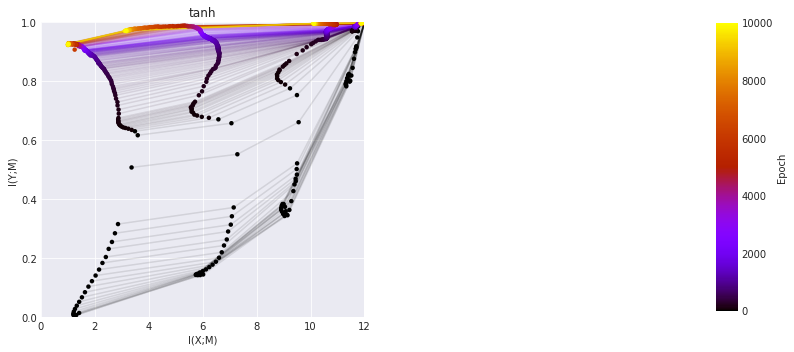

In [6]:
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.title(activation)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

#if DO_SAVE:
#plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')

Plot SNR curves
----

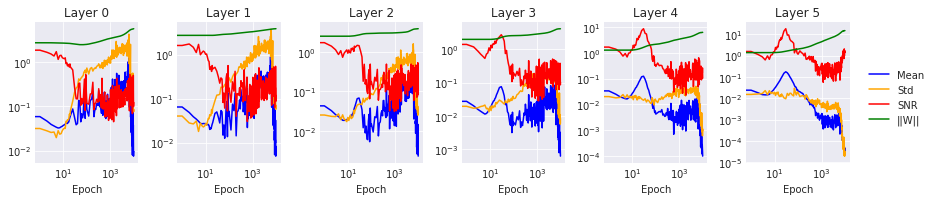

In [8]:
plt.figure(figsize=(12,5))

gs = gridspec.GridSpec(len(measures), len(PLOT_LAYERS))
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        continue
        
    epochs = []
    means = []
    stds = []
    wnorms = []
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        with open(cur_dir + "/"+epochfile, 'rb') as f:
            d = cPickle.load(f)
            
        epoch = d['epoch']
        epochs.append(epoch)
        wnorms.append(d['data']['weights_norm'])
        means.append(d['data']['gradmean'])
        stds.append(d['data']['gradstd'])

    wnorms, means, stds = map(np.array, [wnorms, means, stds])
    for lndx,layerid in enumerate(PLOT_LAYERS):
        plt.subplot(gs[actndx, lndx])
        plt.plot(epochs, means[:,layerid], 'b', label="Mean")
        plt.plot(epochs, stds[:,layerid], 'orange', label="Std")
        plt.plot(epochs, means[:,layerid]/stds[:,layerid], 'red', label="SNR")
        plt.plot(epochs, wnorms[:,layerid], 'g', label="||W||")

        plt.title('Layer %d'%layerid)
        plt.xlabel('Epoch')
        plt.gca().set_xscale("log", nonposx='clip')
        plt.gca().set_yscale("log", nonposy='clip')
    

plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.2))
plt.tight_layout()

#if DO_SAVE:
#    plt.savefig('plots/' + DIR_TEMPLATE % ('snr_'+ARCH), bbox_inches='tight')
